# Data Processing Notebook

## Data Validation
For randomly picked rows, we will check if the data is valid. As data was created with https://www.gurufocus.com, we will use different services like: https://www.alphaspread.com, https://finance.yahoo.com, https://www.investing.com. We will check if the values match with the values from the financial statements for specific periods.

In [ ]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

from sprawozdanie.model_service import calculate_ratios, calculated_features

In [2]:
financial_dataset = pd.read_csv('./data/numerical_dataset_oversampled.csv')
print(financial_dataset.shape)
financial_dataset.head(5)

(36070, 22)


,cik,ticker,label,subset,Fiscal Period,Cost of Goods Sold,Depreciation Depletion Amortization,EBIT,EBITDA,Gross Profit,...,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
0,737874,LI,False,train,Aug 2002,479.0,281.0,1028.0,1310.0,4004.0,...,-1223.0,-10.0,4483.0,3853.0,948.0,695.0,50.0,2562.0,3829.0,570.0
1,737874,LI,False,train,Aug 2003,479.0,281.0,1028.0,1310.0,4004.0,...,-1223.0,-10.0,4483.0,3853.0,948.0,695.0,50.0,2562.0,3829.0,570.0
2,737874,LI,False,train,Aug 2004,483.0,284.0,224.0,507.0,4149.0,...,62.0,52.0,4631.0,3905.0,1032.0,687.0,51.0,2529.0,3928.0,588.0
3,737874,LI,False,train,Aug 2005,579.0,249.0,63.0,312.0,2447.0,...,212.0,249.0,3027.0,2909.0,606.0,448.0,33.0,1309.0,2282.0,203.0
4,737874,LI,False,train,Aug 2006,582.0,216.0,261.0,477.0,2550.0,...,125.0,315.0,3132.0,3039.0,741.0,531.0,41.0,1831.0,2299.0,211.0


In [3]:
financial_data_grouped = financial_dataset.groupby('cik').agg({'label': 'first', 'subset': 'first'})
print(f"Number of companies in the dataset: {financial_data_grouped.shape[0]}")
print(financial_data_grouped['subset'].value_counts(normalize=True))

Number of companies in the dataset: 7214
subset
train    0.798447
test     0.151234
val      0.050319
Name: proportion, dtype: float64


**Dataset overview**

- the dataset contains 7214 companies and is already split into subsets for training and prediction purposes.
- data for 2748 companies (38% of whole dataset) were synthetically generated.
- the dataset has specific structure: each company is represented by five rows, which corresponds to the five years of its financial performance.

**Dataset structure**

- there are 4 columns with metadata:
    - cik - company identifier
    - ticker - company ticker
    - subset - subset of the dataset (train, test, validation)
    - fiscal period - fiscal period of the financial data

- there are 17 financial features, that describe the financial state of the company.
- there is label column, which tells if company will go bankrupt within next year (true) or not (false).

In [6]:
# financial_dataset.sample(5)

(36070, 22)


,cik,ticker,label,subset,Fiscal Period,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,...,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
3835,1043604,JNPR,False,test,Dec 2016,1886.0,207.0,925.0,1132.0,3105.0,...,593.0,-3282.0,4990.0,9657.0,3972.0,1736.0,91.0,4694.0,2212.0,1054.0
2354,1513761,NCLH,False,test,Dec 2020,1693.0,740.0,-3518.0,-2778.0,-413.0,...,-4013.0,-295.0,1280.0,18399.0,3558.0,1914.0,82.0,14045.0,1463.0,21.0
27433,930738,WWCA,False,train,Dec 2003,584.0,276.0,154.0,154.0,918.0,...,0.0,-1129.0,1501.0,2522.0,398.0,383.0,30.0,2724.0,764.0,216.0
25301,914712,STCN,False,train,Jul 2018,544.0,37.1,-5.4,31.7,101.3,...,36.7,-7363.6,645.3,827.0,264.3,276.4,47.8,684.2,122.3,99.3
9436,1641991,FLOW,False,test,Dec 2017,996.0,44.0,87.0,131.0,488.0,...,46.0,-327.0,1483.0,2689.0,1047.0,675.0,294.0,1715.0,391.0,439.0


JNRP (Dec 2016):
- depreciation & amortisation matched: https://www.alphaspread.com/security/nyse/jnpr/financials/cash-flow-statement
- net income matched: https://www.alphaspread.com/security/nyse/jnpr/financials/income-statement/net-income-common

NCLH (Dec 2020):
- depreciation & amortisation matched: https://www.alphaspread.com/security/nasdaq/nclh/financials/cash-flow-statement
- net income matched: https://www.alphaspread.com/security/nyse/nclh/financials/income-statement/net-income-common

WWCA (Dec 2003):
- campany was not found in https://www.alphaspread.com and in https://finance.yahoo.com - probably too old company. Checking net income & revenue & total assets through us sec website with company filings also failed: https://www.sec.gov/Archives/edgar/data/930738/000089102003002613/v93911e10vq.htm
- company merged in August 2005: https://en.wikipedia.org/wiki/Western_Wireless_Corporation

STCN (Jul 2018):
- depreciation & amortisation matched: https://www.alphaspread.com/security/nasdaq/stcn/financials/cash-flow-statement
- net income almost matched (35.4): https://www.alphaspread.com/security/nasdaq/stcn/financials/income-statement/net-income-common

FLOW (Dec 2017):
- net income / total assets / matched: https://www.investing.com/equities/spx-flow-inc-financial-summary

Conclusions
- The data is valid for 4 out of 5 companies. We assume that the data is valid for the rest of the companies as well. Gurufocus service gets data from morningstar, which is a reliable source.


## Dataset Exploration

In [58]:
financial_dataset.isnull().sum().sort_values(ascending=False)

Fiscal Period                               13740
ticker                                      13740
cik                                             0
Net Income                                      0
Total Operating Expense                         0
Total Liabilities                               0
Total Inventories                               0
Total Current Liabilities                       0
Total Current Assets                            0
Total Assets                                    0
Revenue                                         0
Retained Earnings                               0
Market Cap                                      0
Long-Term Debt                                  0
Gross Profit                                    0
EBITDA                                          0
EBIT                                            0
Depreciation, Depletion and Amortization        0
Cost of Goods Sold                              0
subset                                          0


empty values are caused by dataset oversampling. We will not drop them, as other necessary data is valid.
Looks weird, but author of the dataset decided to fill empty values with zeros.

In [59]:
zeros_values_count_per_col = financial_dataset.iloc[:, 5:][financial_dataset == 0].count()
zeros_values_count_per_col.sort_values(ascending=False)

Depreciation, Depletion and Amortization    519
Net Income                                  432
EBIT                                        341
EBITDA                                      285
Long-Term Debt                              269
Retained Earnings                           203
Total Receivables                           128
Cost of Goods Sold                           96
Total Inventories                            80
Gross Profit                                 46
Revenue                                      35
Total Current Liabilities                    16
Total Current Assets                         15
Total Operating Expense                      14
Total Liabilities                            11
Total Assets                                 10
Market Cap                                    3
dtype: int64

In [60]:
all_values_count = financial_dataset.iloc[:, 5:].count().sum()
print(f'Percentage of zeros in the dataset: {zeros_values_count_per_col.sum() / all_values_count * 100:.2f}%')

Percentage of zeros in the dataset: 0.41%


The dataset contains zeros, because missing values were populated with zeros and data could contain zeros (i.e.: for feature Net Income company might not have any income in specific period).
Percentage of zeros in the dataset is low

In [61]:
financial_data_grouped = financial_dataset.groupby('cik').agg({'label': 'first', 'subset': 'first', 'ticker': 'first'})
financial_data_grouped.shape

(7214, 3)

In [62]:
financial_data_grouped['label'].value_counts(normalize=True)

label
False    0.608816
True     0.391184
Name: proportion, dtype: float64

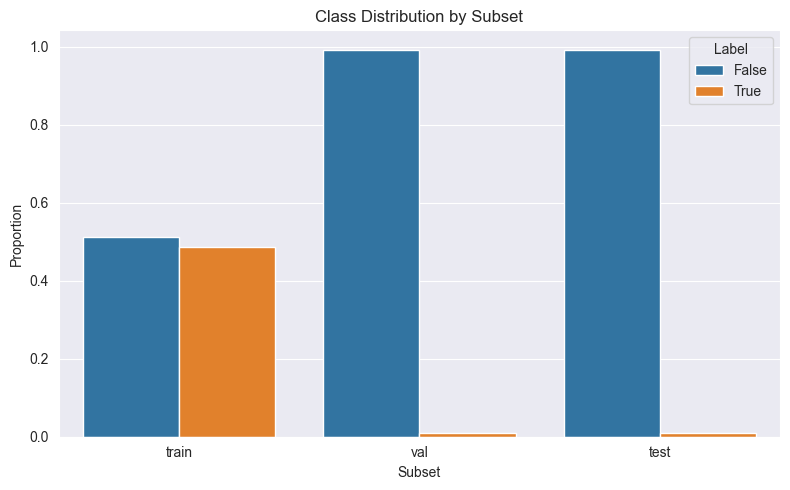

In [63]:
# Calculate normalized value counts for each subset
subsets = ['train', 'val', 'test']
data = []
for subset in subsets:
    counts = financial_data_grouped[financial_data_grouped['subset'] == subset]['label'].value_counts(normalize=True)
    for label, proportion in counts.items():
        data.append({'subset': subset, 'label': label, 'proportion': proportion})

df_plot = pd.DataFrame(data)

plt.figure(figsize=(8, 5))
sns.barplot(data=df_plot, x='subset', y='proportion', hue='label', order=subsets, hue_order=[False, True])
plt.title('Class Distribution by Subset')
plt.ylabel('Proportion')
plt.xlabel('Subset')
plt.legend(title='Label')
plt.tight_layout()
plt.show()

The dataset is balanced, so we can use it for training machine learning models, without any additional balancing.
We also see that validation and test subsets have distribution of classes, that is probably similar to the natural distribution of bankrupt and non-bankrupt companies.

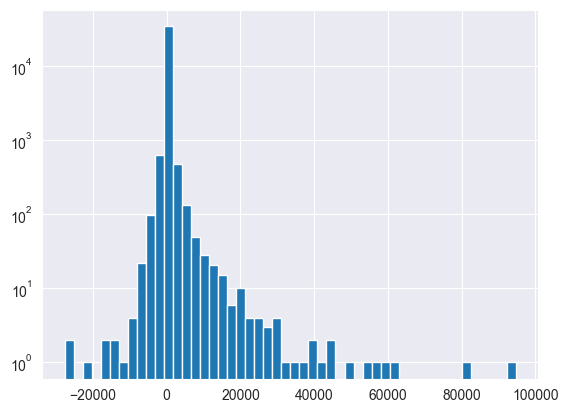

In [4]:
plt.hist(financial_dataset['Net Income'].values, bins=50)
plt.yscale('log')

/Users/grzegorzpozorski/PyCharmProjects/bankruptcy-forecasting/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/grzegorzpozorski/PyCharmProjects/bankruptcy-forecasting/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/grzegorzpozorski/PyCharmProjects/bankruptcy-forecasting/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/grzegorzpozorski/PyCharmProjects/bankruptcy-forecasting/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/grzegorzpozorski/PyCharmProjects/bankruptcy-forecasting/.venv/l

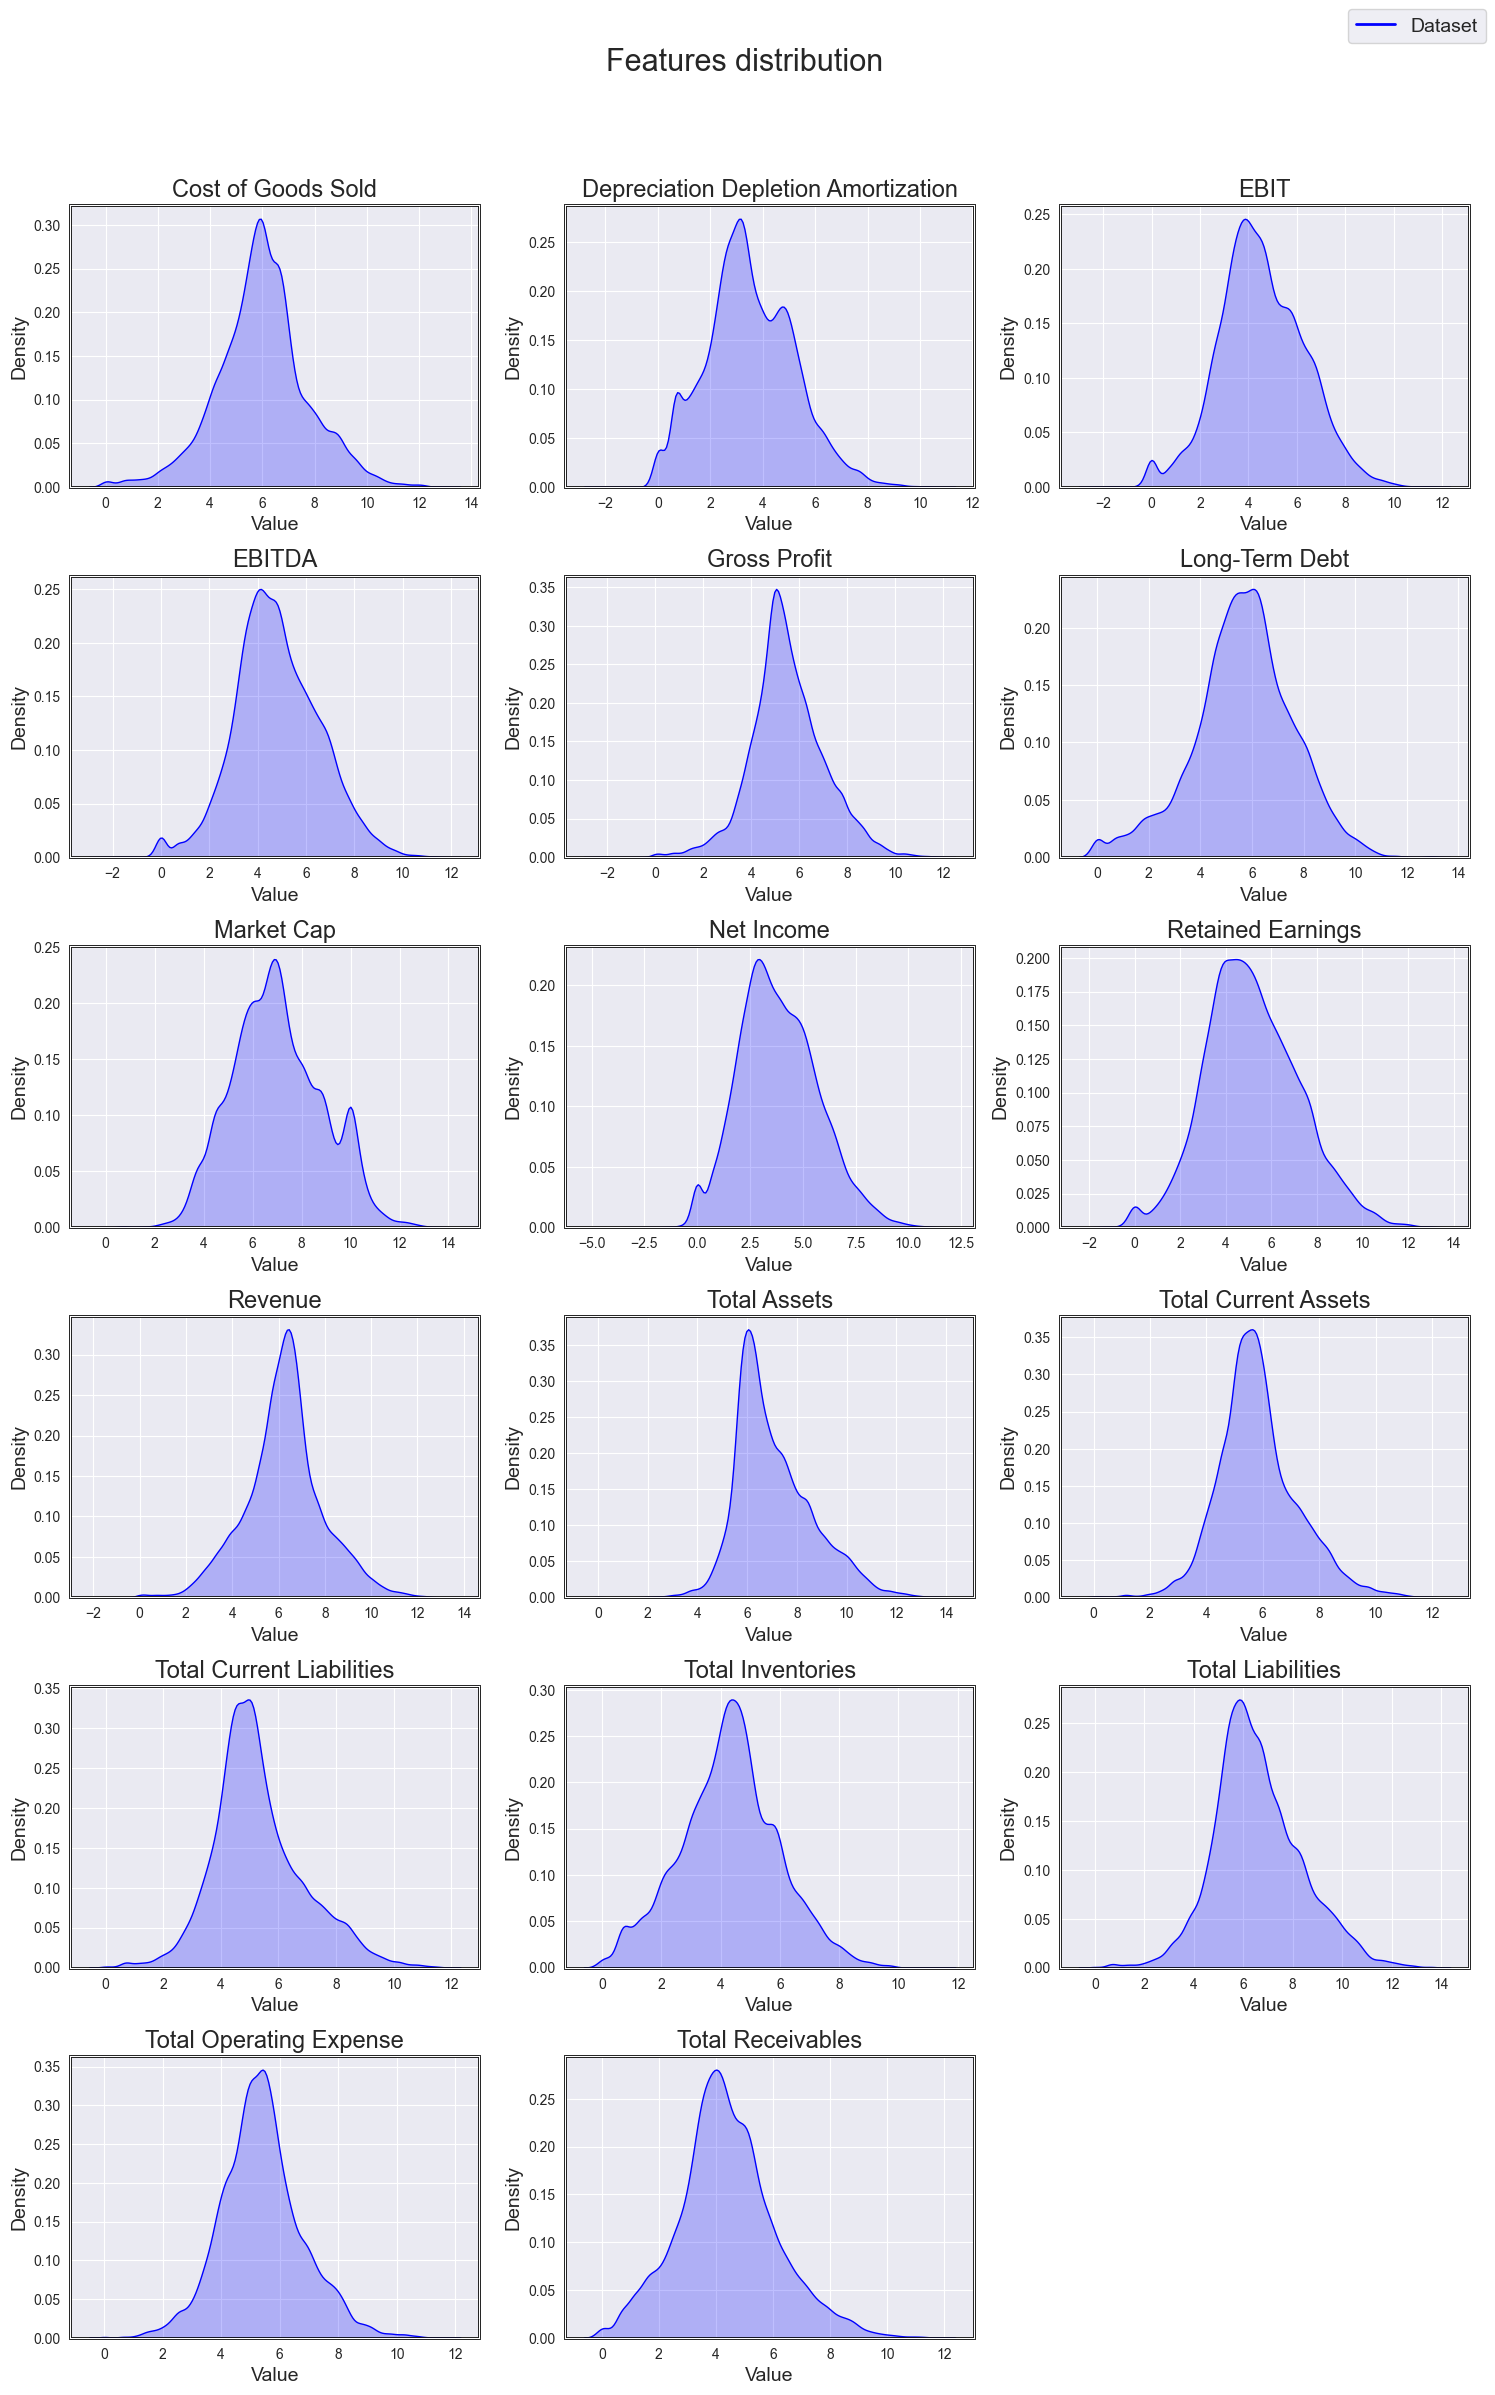

In [5]:
financial_dataset_features_dist_plot = pd.read_csv('./data/numerical_dataset_oversampled.csv')
financial_dataset_features_dist_plot.drop(['cik', 'ticker', 'Fiscal Period', 'label', 'subset'], axis=1, inplace=True)

features = financial_dataset_features_dist_plot.select_dtypes(include=['float64', 'int64']).columns

n_cols = 3
n_rows = math.ceil(len(features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
fig.suptitle('Features distribution', fontsize=22)

axes = axes.flatten()

for idx, column in enumerate(features):
    df1_log = np.log1p(financial_dataset_features_dist_plot[column])

    sns.kdeplot(df1_log, fill=True, ax=axes[idx], color='blue')
    axes[idx].set_title(f'{column}', fontsize=17)
    axes[idx].set_xlabel('Value', fontsize=14)
    axes[idx].set_ylabel('Density', fontsize=14)

    axes[idx].add_patch(Rectangle(
        (0, 0), 1, 1, transform=axes[idx].transAxes,
        fill=False, color='black', lw=2, clip_on=False))

for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

handles = [
    plt.Line2D([0], [0], color='blue', lw=2, label='Dataset')
]

fig.legend(handles=handles, loc='upper right', ncol=1, fontsize=14)

plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()

## Data Enrichment

There are several important indicators that are not present in the dataset, but can be calculated from the existing features.

In [66]:
financial_dataset.columns

Index(['cik', 'ticker', 'label', 'subset', 'Fiscal Period',
       'Cost of Goods Sold', 'Depreciation, Depletion and Amortization',
       'EBIT', 'EBITDA', 'Gross Profit', 'Long-Term Debt', 'Market Cap',
       'Net Income', 'Retained Earnings', 'Revenue', 'Total Assets',
       'Total Current Assets', 'Total Current Liabilities',
       'Total Inventories', 'Total Liabilities', 'Total Operating Expense',
       'Total Receivables'],
      dtype='object')

In [70]:
enriched = calculate_ratios(financial_dataset.copy())

Now we check if the features were calculated correctly. We will compare them with the values from https://www.gurufocus.com/stock/ADNT/financials.
We will compare the values for the companies with tickers: 'ADNT' and 'PAYX' as they have relatively fresh data (up to 2021) and are easily accessed on gurufocus.

In [71]:
def extract_year(period):
    try:
        return int(str(period)[-4:])
    except Exception:
        return np.nan

enriched['Fiscal Year'] = enriched['Fiscal Period'].apply(extract_year)
filtered = enriched[(enriched['Fiscal Year'] > 2020)]

filtered.head(20)[calculated_features + ['ticker', 'Fiscal Period']]

,Net Profit Margin percentage,EBITDA Margin percentage,Gross Profit Margin percentage,ROA percentage,Current Ratio,Quick Ratio,Liabilities-to-Assets Ratio,Total Equity,Equity-to-Asset,Asset Turnover,Receivables Turnover,Inventory Turnover,PE Ratio,ticker,Fiscal Period
24,26.650943,29.952830,80.896226,15.127175,6.108527,5.480620,0.110442,1329.00,0.889558,0.567604,8.742268,2.000000,63.845133,ABMD,Mar 2021
194,8.099415,14.802632,6.038012,10.280200,1.448590,1.170607,0.725552,2958.00,0.274448,1.269252,9.593268,13.170082,3.530686,ADNT,Sep 2021
284,-4.818841,-2.920290,34.094203,-4.829690,1.546859,0.915808,0.810153,2614.00,0.189847,1.002251,17.875648,3.710730,-11.389474,GPS,Jan 2021
639,27.064333,40.966231,68.671432,11.899859,1.249494,1.246679,0.680503,2948.00,0.319497,0.439688,3.849146,91.438849,33.142077,PAYX,May 2021
764,4.480841,8.127318,28.924598,6.382042,2.796729,1.948598,0.589349,933.00,0.410651,1.424296,6.271318,6.336088,24.186207,AIT,Jun 2021
874,20.887246,36.845348,25.138632,11.940824,3.917160,2.520710,0.521310,1359.00,0.478690,0.571680,10.820000,5.144068,16.799410,EXP,Mar 2021
989,94.762457,11.808314,24.039407,15.291072,2.531392,1.651501,0.374034,3945.52,0.625966,0.161362,39.901138,3.494312,3.381206,PSEC,Jun 2021
1004,0.325851,10.970311,42.324403,0.145655,3.916667,2.708333,0.386794,378.90,0.613206,0.446998,2.935175,2.496865,719.555556,THR,Mar 2021
1049,-40.735756,-30.686406,75.459847,-15.473756,2.145574,2.119344,0.728357,1594.00,0.271643,0.379857,2.000898,13.675000,-29.651982,SPLK,Jan 2021
1074,-0.879306,10.057817,65.369790,-0.223837,1.098247,1.093519,0.543740,1488.00,0.456260,0.254561,3.417867,52.290909,-338.794521,VRNT,Jan 2021


Matching ratios:
- 'Net Profit Margin'
- 'EBITDA Margin'
- 'Gross Profit Margin'
- 'Current Ratio'
- 'Quick Ratio'
- 'Liabilities-to-Assets Ratio'
- 'Asset Turnover Ratio'
- 'P/E Ratio'
- 'Receivables Turnover' (similar: difference is caused by taking 'Total Receivables' instead of 'Average Accounts Receivable')
- 'Inventory Turnover' (similar: difference is caused by taking 'Total Inventories' instead of 'Average Inventory')
- 'ROA' (almost same: difference is caused by taking 'Total Assets' instead of 'Average Total Assets')
- 'Equity-to-Asset' (almost same: difference is caused by taking 'Total Assets' instead of 'Average Total Assets')

After checking the data, it turns out that the following features cannot be calculated from the existing features or are not valid, so features were deleted:
- 'Operating Profit Margin' - necessary feature 'Operating Income' is not present in the dataset, so we cannot calculate it. Using 'EBIT' instead of 'Operating Income' would not be correct, as EBIT is calculated differently.
- 'Debt to equity ratio' - Debt to equity ratio = Total Liabilities / Shareholders' Equity, where Shareholders' Equity = Total Assets - Total Liabilities, but it's not working
- 'Debt to assets ratio' - 'Total Debt' is not present in the dataset, so we cannot calculate it.
- 'Enterprise Value' - EV = Market Cap + Total Debt - Cash and Cash Equivalents, but 'Total Debt' and 'Cash and Cash Equivalents' is not present in the dataset, so we cannot calculate it.
- 'EV/EBITDA Ratio' - we don't have 'Enterprise Value'
- 'ROE' - needs 'Shareholders' Equity', which is not present in the dataset, so we cannot calculate it.


In [72]:
enriched[calculated_features] = enriched[calculated_features].round(2)
enriched.head()

,cik,ticker,label,subset,Fiscal Period,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,...,Current Ratio,Quick Ratio,Liabilities-to-Assets Ratio,Total Equity,Equity-to-Asset,Asset Turnover,Receivables Turnover,Inventory Turnover,PE Ratio,Fiscal Year
0,737874,LI,False,train,Aug 2002,479.0,281.0,1028.0,1310.0,4004.0,...,1.36,1.29,0.66,1291.0,0.34,1.16,7.86,9.58,-0.14,2002.0
1,737874,LI,False,train,Aug 2003,479.0,281.0,1028.0,1310.0,4004.0,...,1.36,1.29,0.66,1291.0,0.34,1.16,7.86,9.58,-0.14,2003.0
2,737874,LI,False,train,Aug 2004,483.0,284.0,224.0,507.0,4149.0,...,1.50,1.43,0.65,1376.0,0.35,1.19,7.88,9.47,2.84,2004.0
3,737874,LI,False,train,Aug 2005,579.0,249.0,63.0,312.0,2447.0,...,1.35,1.28,0.45,1600.0,0.55,1.04,14.91,17.55,0.83,2005.0
4,737874,LI,False,train,Aug 2006,582.0,216.0,261.0,477.0,2550.0,...,1.40,1.32,0.60,1208.0,0.40,1.03,14.84,14.20,1.41,2006.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36065,1473078,CHSPPRACL.PFD,False,train,Dec 2014,325.0,52.0,89.0,141.0,153.0,...,1.81,1.77,0.37,1082.0,0.63,0.28,36.77,162.50,1.77,2014.0
36066,1473078,CHSPPRACL.PFD,False,train,Dec 2015,392.0,70.0,102.0,172.0,191.0,...,1.97,1.94,0.42,1210.0,0.58,0.28,36.44,196.00,1.59,2015.0
36067,1473078,CHSPPRACL.PFD,False,train,Dec 2016,415.0,75.0,111.0,186.0,204.0,...,1.80,1.77,0.42,1188.0,0.58,0.30,31.00,207.50,1.40,2016.0
36068,1473078,CHSPPRACL.PFD,False,train,Dec 2017,395.0,77.0,113.0,190.0,203.0,...,1.77,1.74,0.47,1048.0,0.53,0.30,28.48,197.50,1.42,2017.0


In [73]:
enriched.drop(['Fiscal Year'], axis=1, inplace=True)
enriched[calculated_features] = enriched[calculated_features].fillna(0)
print(f"Nans in the dataset: {enriched.drop(['Fiscal Period', 'ticker'], axis=1).isnull().sum().sum()}")

Nans in the dataset: 0


In [74]:
enriched.to_csv('./data/numerical_dataset_oversampled_with_ratios.csv', index=False)
enriched.shape

(36070, 35)

In [75]:
enriched_zeros_values_count_per_col = enriched.iloc[:, 5:][enriched == 0].count()
enriched_all_values_count = enriched.iloc[:, 5:].count().sum()
enriched_zeros_values_count_per_col.sort_values(ascending=False)

Depreciation, Depletion and Amortization    519
Net Profit Margin percentage                467
ROA percentage                              444
PE Ratio                                    440
Net Income                                  432
EBIT                                        341
EBITDA Margin percentage                    320
EBITDA                                      285
Long-Term Debt                              269
Inventory Turnover                          215
Retained Earnings                           203
Receivables Turnover                        146
Asset Turnover                              128
Total Receivables                           128
Equity-to-Asset                             118
Cost of Goods Sold                           96
Total Inventories                            80
Quick Ratio                                  69
Gross Profit Margin percentage               67
Gross Profit                                 46
Liabilities-to-Assets Ratio             

In [76]:
print(f'Percentage of zeros in the dataset: {enriched_zeros_values_count_per_col.sum() / enriched_all_values_count * 100:.2f}%')

Percentage of zeros in the dataset: 0.46%


We observed that the percentage of zeros rose by 0.05%, but is still very low in the dataset.

## Prepare dataset for model training
After initial exploration and experimentation with several models, it turns out that dataset proposed split to train, test and val subsets results in weird results, i.e.: tested XGBClassifier obtains totally different values of precision metric.
Decided to create own split only into train and test and move dataset preparation be done right before model training.


Dropping metadata columns, that are not needed for model training. We will keep only cik, label and features. Cik is needed for grouping the data and (de)flattening.

In [10]:
dataset = pd.read_csv('./data/numerical_dataset_original.csv')
dataset.drop(['cik', 'subset', 'ticker', 'Fiscal Period'], axis=1, inplace=True)
dataset.to_csv('./data/dataset.csv', index=False)
dataset.head()

,label,Cost of Goods Sold,Depreciation Depletion Amortization,EBIT,EBITDA,Gross Profit,Long-Term Debt,Market Cap,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
0,False,246.5,5.5,30.0,35.5,56.2,3.9,171.0,33.6,-113.7,302.7,275.1,154.0,117.6,77.1,207.3,26.2,96.2
1,False,268.5,6.9,18.6,25.5,56.6,0.6,203.3,36.3,-77.4,325.2,307.8,185.3,123.7,77.1,201.2,38.0,110.8
2,False,312.1,8.8,20.9,29.7,60.8,0.1,185.0,12.1,-65.4,372.9,335.6,221.0,132.2,77.1,211.1,39.9,160.0
3,False,337.3,9.3,30.7,40.0,77.4,0.1,309.4,19.4,-45.9,414.6,362.9,234.3,144.2,77.1,215.4,46.6,179.7
4,False,402.3,14.7,2.2,16.9,79.0,79.2,196.4,0.0,-45.9,481.3,478.5,248.2,178.4,77.1,325.1,77.7,199.3
